# Project 1 - Recommender system for movies

## Data and methods

Let us start by reading the data:

In [1]:
from pyspark.sql.session import SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
data = spark.read.csv("ratings.csv", header='true').drop('timestamp')
data.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      2|   3.5|
|     1|     29|   3.5|
|     1|     32|   3.5|
|     1|     47|   3.5|
|     1|     50|   3.5|
|     1|    112|   3.5|
|     1|    151|   4.0|
|     1|    223|   4.0|
|     1|    253|   4.0|
|     1|    260|   4.0|
|     1|    293|   4.0|
|     1|    296|   4.0|
|     1|    318|   4.0|
|     1|    337|   3.5|
|     1|    367|   3.5|
|     1|    541|   4.0|
|     1|    589|   3.5|
|     1|    593|   3.5|
|     1|    653|   3.0|
|     1|    919|   3.5|
+------+-------+------+
only showing top 20 rows



The entries of our dataframes are strings, we need to convert them into **numeric** ones so that we can apply our algorithms:

In [4]:
from pyspark.sql.types import DoubleType, IntegerType

data = data.withColumn("movieId", data["movieId"].cast(IntegerType()))
data = data.withColumn("userId", data["userId"].cast(IntegerType()))
data = data.withColumn("rating", data["rating"].cast(DoubleType()))

In [5]:
data.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)



## Sampling the data

Let us build our dataset for this homework:

In [6]:
import pandas as pd
data = pd.read_csv('ratings.csv').drop('timestamp', axis=1)

In [7]:
data.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [8]:
counts = data['movieId'].value_counts()
data = data[data['movieId'].isin(counts.index[counts > 5000])]
data.groupby('movieId').nunique().count()

userId     1005
movieId    1005
rating     1005
dtype: int64

Here we selected the 1,005 movies that have more than 5,000 ratings.

In [9]:
data.groupby('userId').nunique().count()

userId     138476
movieId    138476
rating     138476
dtype: int64

There are 138,476 distinct users in our dataset. Let us select randomly some of them to build our dataset.

In [10]:
import numpy as np
np.random.seed(1)
sample = data['userId'].unique()
sample_users = np.random.choice(sample, 10000)
sample_users

array([128053,   5194,  50065, ...,  90167,  70032,  49250])

In [11]:
dataset = data.loc[data['userId'].isin(sample_users)]
dataset

,userId,movieId,rating
922,10,1,4.0
923,10,11,4.0
924,10,25,4.0
925,10,260,4.0
926,10,356,3.0
...,...,...,...
19999279,138484,733,3.0
19999280,138484,736,4.0
19999281,138484,748,3.0
19999282,138484,780,5.0


In [12]:
dataset.groupby('movieId').nunique().count()

userId     1005
movieId    1005
rating     1005
dtype: int64

In [13]:
dataset.groupby('userId').nunique().count()

userId     9672
movieId    9672
rating     9672
dtype: int64

Finally, our dataset contains 1,005 distinct movies and 9,675 users.

Let us now split our datset in a train set and a test set. We will use both of them for the rest of our study in this homework:

In [14]:
dataset = spark.createDataFrame(dataset)

In [15]:
(training, test) = dataset.randomSplit([0.8,0.2], seed=0)

In [16]:
print(training.count(), test.count())

712334 178242


## Statistics

We can make some statistics about our new set of movies to better understand it. Here is the number of ratings each movie has:

In [17]:
stat = dataset.groupBy("movieId").count().sort('count', ascending=False)
stat.show()

+-------+-----+
|movieId|count|
+-------+-----+
|    296| 4654|
|    356| 4563|
|    318| 4403|
|    593| 4400|
|    480| 4038|
|    110| 3753|
|    260| 3738|
|    589| 3561|
|   2571| 3532|
|      1| 3437|
|    527| 3416|
|    457| 3365|
|    150| 3256|
|    780| 3252|
|     50| 3221|
|   1210| 3203|
|     32| 3185|
|    592| 3101|
|   2858| 3099|
|    608| 3031|
+-------+-----+
only showing top 20 rows



In [18]:
stat.describe('count').show()

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|             1005|
|   mean|886.1452736318408|
| stddev|651.5892025154428|
|    min|              326|
|    max|             4654|
+-------+-----------------+



Here we can see the number of ratings with respect to the number of movies:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120b74150>]],
      dtype=object)

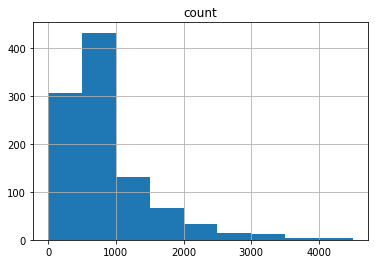

In [19]:
%matplotlib inline
import pandas as pd

panda_stat = stat.toPandas()

bin_ = [i*500 for i in range(10)]

panda_stat.hist(column='count', bins=bin_)

We can observe that the vast majority of the movies have less than 1,000 ratings and just a few of them have more ratings. This is the long tail effect: the popular movies (that represent a small proportion of the overall dataset) are far more rated than the other ones. 

# Metrics

In this section, we will define the metrics functions which we will use later to assess the performances of our models:
- MAE
- RMSE
- precision

MAE and RMSE:

In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def RMSE(y_predicted, y):
    rmse = np.sqrt(mean_squared_error(y, y_predicted))
    return("RMSE = " + str(rmse))

Precision:

In [21]:
# Let us first create a function to transform our raw predictions into appropriate ones.
def round_rating(x): 
    dec = x - int(x)
    if (dec >= 0.25) and (dec < 0.75):
        return int(x) + 0.5
    else:
        return int(x) + (dec > 0.5)

# Precision function metric:
def precision(y, y_predicted):
    y_predicted = [round_rating(k) for k in y_predicted]       
    TP = 0
    for i in range(len(y)):
        if y[i] == y_predicted[i]:
            TP += 1
    return TP/len(y)

## Baseline Model

Since most collaborative filtering methods start off with a simple baseline model, we will begin by implementing the following model to our data:
<br><br>
$$r_{ui}=\mu + \beta_u + \beta_i$$
<br>
with: 
* $\mu$: global average rating
* $\beta_u$: user bias
* $\beta_i$: item bias
<br><br>
This non-personalized bias model predicts the ratings given by a user only by taking into account the user generosity and item popularity, rather than specific and personalized interests of users in items.

Let us calculate $\mu$ first:

In [22]:
training.describe("rating").show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|            712334|
|   mean| 3.639545494108101|
| stddev|1.0158713154695678|
|    min|               0.5|
|    max|               5.0|
+-------+------------------+



In [23]:
mu = 3.639545494108101

Now, let us compute the $\beta_i$:

In [24]:
item_mean = training.groupby('movieId').mean("rating")
#item_mean.show()

In [25]:
item_bias = item_mean.toPandas()
item_bias['item_bias'] = mu - item_bias['avg(rating)']

In [26]:
# Let us transform the pandas dataframe into a Spark one. 
# This operation is purely aesthetic - we found it looks better to show the results under this format.

item_bias = spark.createDataFrame(item_bias).drop('avg(rating)')
item_bias.show()

+-------+--------------------+
|movieId|           item_bias|
+-------+--------------------+
|     29|-0.31661316977498855|
|    474|-0.10794446573125649|
|   2529|0.025175992641825573|
|    541| -0.4731643380261916|
|   5418| -0.2855591084023592|
|   1258| -0.3343641632127712|
|    293| -0.4674996495307502|
|   1127|-0.01245041172608...|
|   1371| 0.41932888760990616|
|   8636| 0.06542918852087176|
|   1409|  0.6291597374315434|
|   2581|  0.5827887373513443|
|   3704| 0.46820593024517265|
|    222| 0.06043157005746824|
|   2797| 0.05387133680473033|
|   2944|-0.24862931308984226|
|    367|  0.4957205853014308|
|    442|   0.609795014261652|
|    720|-0.44993996450487383|
|   1175|   -0.40831344795739|
+-------+--------------------+
only showing top 20 rows



Similarly, we can compute the $\beta_u$:

In [27]:
user_mean = training.groupby('userId').mean("rating")
#user_mean.show()

In [28]:
user_bias = user_mean.toPandas()
user_bias['user_bias'] = mu - user_bias['avg(rating)']

In [29]:
# Let us transform the pandas dataframe into a Spark one. 
# This operation is purely aesthetic - we found it looks better to show the results under this format.

user_bias = spark.createDataFrame(user_bias).drop('avg(rating)')
user_bias.show()

+------+--------------------+
|userId|           user_bias|
+------+--------------------+
|  2509| -0.5912237366611297|
|  9715|-0.23545450589189887|
| 15663|-0.26954541498280804|
| 15846|  0.2917194071515792|
| 17043|-0.04650101751980573|
| 18147| 0.11013372940221888|
| 23116|  0.5681169226795295|
| 26543| 0.11013372940221888|
| 30025| -0.1786363240737172|
| 30428|  0.7958700764470032|
| 32954|-0.37327501871241164|
| 33862|-0.02712117255856...|
| 38543| -0.5709808216813723|
| 42852| 0.23478358934619648|
| 48280|  1.0581501452708917|
| 50219| 0.09409094865355572|
| 53509|-0.19598082168137276|
| 53721|-0.09378783922523226|
| 54039|-0.08045450589189906|
| 72203| 0.24668835125095834|
+------+--------------------+
only showing top 20 rows



Hence, here is a function to predict the rating a user would give to an item - based on our baseline model:

In [30]:
# Let us re-transform our Spark dataframes into Pandas ones for easier computations. 

item_bias = item_bias.toPandas().set_index('movieId')
user_bias = user_bias.toPandas().set_index('userId')

In [31]:
def baseline_rating(userId, movieId):
    if movieId not in item_bias.index:
        return mu
    elif userId not in user_bias.index:
        return mu
    else:
        return mu + item_bias.loc[movieId, 'item_bias'] + user_bias.loc[userId, 'user_bias']

Let us now assess how our baseline model performs on our test set. We will thus be able to compare this model to the other ones then. 

In [32]:
pd_test = test.toPandas()
pd_test.head()

,userId,movieId,rating
0,10,1,4.0
1,10,260,4.0
2,10,527,5.0
3,10,1250,4.0
4,10,1304,3.0


In [33]:
y_predicted = []

for i in range(len(pd_test.index)):
    movieId = pd_test.iloc[i, 1]
    userId = pd_test.iloc[i, 0]
    y_predicted.append(baseline_rating(userId, movieId))

In [34]:
y = pd_test['rating'].values

In [35]:
pd_test['baseline_rating'] = y_predicted
pd_test.head()

,userId,movieId,rating,baseline_rating
0,10,1,4.0,3.082961
1,10,260,4.0,2.794382
2,10,527,5.0,2.678454
3,10,1250,4.0,2.926363
4,10,1304,3.0,2.940234


In [36]:
stat_1 = spark.createDataFrame(pd_test)
stat_1.describe('baseline_rating').show()

+-------+------------------+
|summary|   baseline_rating|
+-------+------------------+
|  count|            178242|
|   mean|3.6398968744318725|
| stddev|0.6129913795236411|
|    min|1.6503683761614605|
|    max| 7.643023206711027|
+-------+------------------+



In [37]:
mae_baseline_1 = mean_absolute_error(y, y_predicted)
rmse_baseline_1 = RMSE(y, y_predicted)
precision_baseline_1 = precision(y, y_predicted)

print('MAE: ', mae_baseline_1, '\n', rmse_baseline_1, '\nprecision: ', precision_baseline_1)

MAE:  1.1506927386312016 
 RMSE = 1.4410602572570943 
precision:  0.1298291087398032


**We can observe the RMSE for this baseline model is quite bad.**
As stated previously, the ratings are done by taking into account the user generosity and item popularity, rather than specific and personalized interests of users in items. That is why the predictions are not accurate. 

### Assessment of another baseline model

Another simpler baseline model would be to return the global average ratings for all the movies and users as following:
<br><br>
$$r_{ui}=\mu $$
<br>
with $\mu$, the global average rating.

In [39]:
y_predicted = [mu for i in range(len(y))]

In [40]:
# Assessment of this baseline model on our test set:

mae_baseline_2 = mean_absolute_error(y, y_predicted)
rmse_baseline_2 = RMSE(y, y_predicted)
precision_baseline_2 = precision(y, y_predicted)

print('MAE: ', mae_baseline_2, '\n', rmse_baseline_2, '\nprecision: ', precision_baseline_2)

MAE:  0.8195743288512253 
 RMSE = 1.0181109771997578 
precision:  0.1013453619236768


We can observe that this simpler baseline actually returns better results than the previous one. **The precision is a bit lower, but the RMSE is much lower which means that, in general, our predictions are closer to the real ones**. <br>  We will thus use this model for our homework to compare the performances of the personalized models we are going to build later.

---